<a href="https://colab.research.google.com/github/meeks627/BeyondAI-KANs-vs-MLPs-Colab-Code/blob/main/My_BeyondAI_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
!pip install imodelsx

In [44]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imodelsx import KANClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.metrics import roc_curve,auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings(action='ignore')

##Initialize model

In [45]:
# KAN model
# Default parameter for  KANClassifier are as follows:
# regularize_activation = 1.0
# regularize_entropy = 1.0
# regularize_ridge = 0.0
# grid_size = 5
# spline_order = 3
# scale_noise = 0.1
# scale_base = 1.0
# scale_spline = 1.0
# base_activation = torch.nn.SILU
# grid_eps = 0.02
# grid_range = [-1,1]
kan = KANClassifier(device='cpu')

# MLP model
mlp =  MLPClassifier(hidden_layer_sizes=(64, 32),
                     activation='tanh',
                     solver='sgd',
                     learning_rate_init=0.01,
                     alpha=0.1,
                     max_iter=1,
                     random_state=42,
                     verbose= False)

## Load Data

In [46]:
url_wine = 'https://gist.githubusercontent.com/tijptjik/9408623/raw/b237fa5848349a14a14e5d4107dc7897c21951f5/wine.csv'
df = pd.read_csv(url_wine)
x = df.drop('Wine', axis=1).values
y = df['Wine'].values

##Prepare Data

In [47]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)
# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)
X_test = scaler.transform(x_test)
# Converting data to tensors
X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

## Computing the Functions


In [48]:
# Train and evaluate MLP over epochs
def mlp_run(mlp, x_train, y_train, x_test, y_test, num_epochs):
    train_accuracies, test_accuracies = [], []
    train_losses, test_losses = [], []
    criterion = nn.MSELoss()

    for epoch in range(num_epochs):
        mlp.partial_fit(X_train, y_train, classes=np.unique(y_train))  # Incremental training
        y_pred_train = mlp.predict(X_train)
        y_pred_test = mlp.predict(X_test)

        train_acc = accuracy_score(y_train, y_pred_train)
        test_acc = accuracy_score(y_test, y_pred_test)
        train_loss = criterion(torch.tensor(y_pred_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
        test_loss = criterion(torch.tensor(y_pred_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        train_losses.append(train_loss.item())
        test_losses.append(test_loss.item())
    return train_accuracies, test_accuracies, train_losses, test_losses

# Train and evaluate KAN over epochs
def kan_run(kan, x_train, y_train, x_test, y_test, num_epochs):
    train_accuracies, test_accuracies = [], []
    train_losses, test_losses = [], []
    criterion = nn.MSELoss()

    for epoch in range(num_epochs):
        kan.fit(X_train, y_train)
        y_pred_train = kan.predict(X_train)
        y_pred_test = kan.predict(X_test)

        train_acc = accuracy_score(y_train, y_pred_train)
        test_acc = accuracy_score(y_test, y_pred_test)
        train_loss = criterion(torch.tensor(y_pred_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
        test_loss = criterion(torch.tensor(y_pred_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        train_losses.append(train_loss.item())
        test_losses.append(test_loss.item())
    return train_accuracies, test_accuracies, train_losses, test_losses

def plot_comparison_over_epochs(mlp_metrics, kan_metrics, num_epochs):
    epochs = range(1, num_epochs + 1)

    mlp_train_acc, mlp_test_acc, mlp_train_loss, mlp_test_loss = mlp_metrics
    kan_train_acc, kan_test_acc, kan_train_loss, kan_test_loss = kan_metrics

    plt.figure(figsize=(14, 10))

    # Training Accuracy
    plt.subplot(221)
    plt.plot(epochs, mlp_train_acc, label='MLP Train Accuracy', marker='o')
    plt.plot(epochs, kan_train_acc, label='KAN Train Accuracy', marker='x')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy Over Epochs')
    plt.legend()

    # Testing Accuracy
    plt.subplot(222)
    plt.plot(epochs, mlp_test_acc, label='MLP Test Accuracy', marker='o')
    plt.plot(epochs, kan_test_acc, label='KAN Test Accuracy', marker='x')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Testing Accuracy Over Epochs')
    plt.legend()

    # Training Loss
    plt.subplot(223)
    plt.plot(epochs, mlp_train_loss, label='MLP Train Loss', marker='o')
    plt.plot(epochs, kan_train_loss, label='KAN Train Loss', marker='x')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()

    # Testing Loss
    plt.subplot(224)
    plt.plot(epochs, mlp_test_loss, label='MLP Test Loss', marker='o')
    plt.plot(epochs, kan_test_loss, label='KAN Test Loss', marker='x')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Testing Loss Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

##Running the Code

 55%|█████▌    | 55/100 [00:02<00:02, 21.20it/s]


	Early stopping


 54%|█████▍    | 54/100 [00:01<00:01, 41.18it/s]


	Early stopping


 62%|██████▏   | 62/100 [00:00<00:00, 82.37it/s]


	Early stopping


 60%|██████    | 60/100 [00:01<00:00, 54.66it/s]


	Early stopping


100%|██████████| 100/100 [00:01<00:00, 87.81it/s]


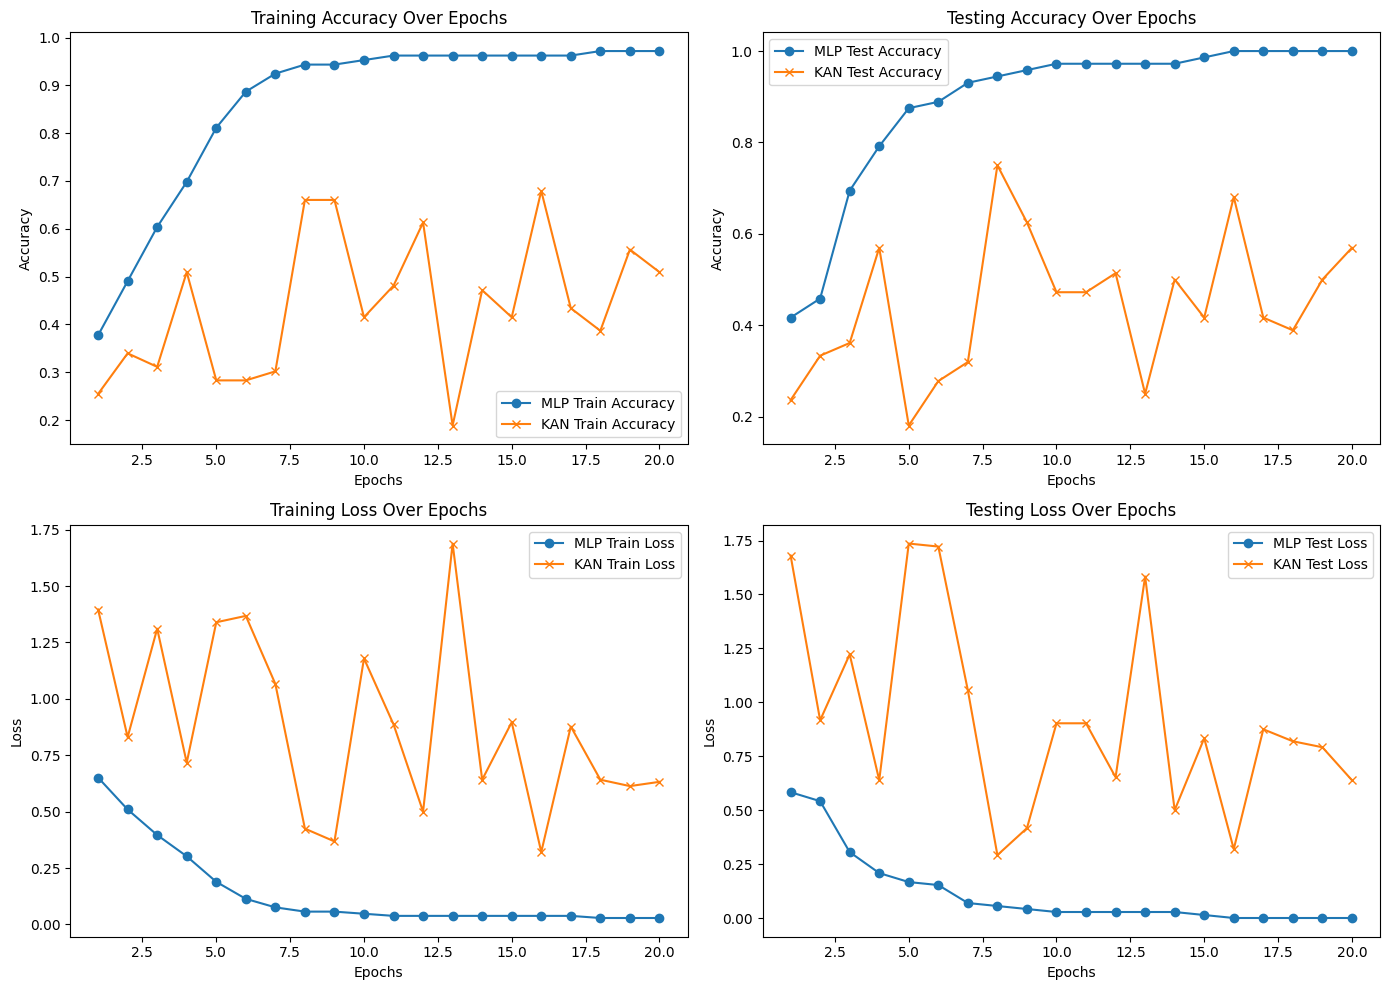

In [49]:
num_epochs = 20
mlp_metrics = mlp_run(mlp, x_train, y_train, x_test, y_test, num_epochs)
kan_metrics = kan_run(kan, x_train, y_train, x_test, y_test, num_epochs)
plot_comparison_over_epochs(mlp_metrics, kan_metrics, num_epochs)

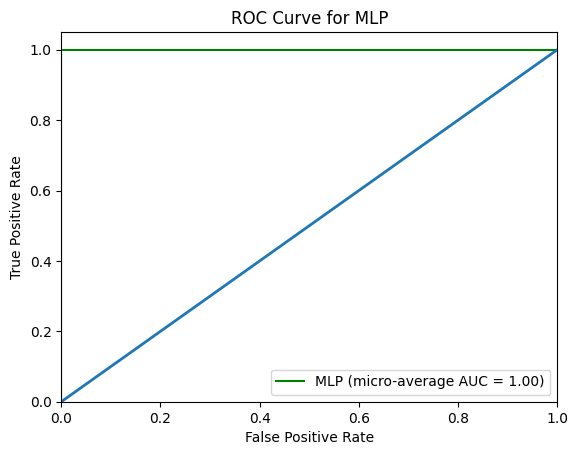

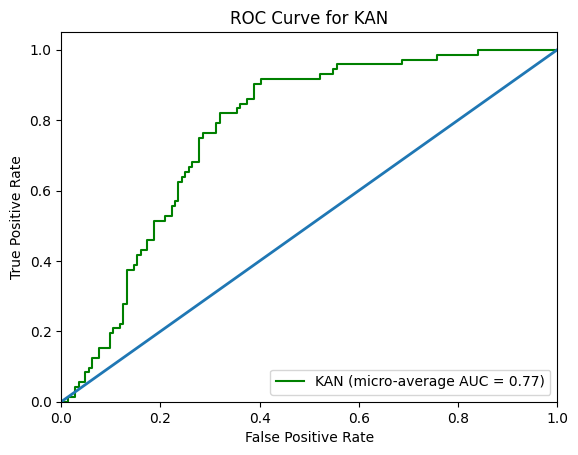

In [50]:
def plot_roc_auc(y_true, y_pred_prob, model_name):
  n_classes = y_pred_prob.shape[1]
  y_true_bin = label_binarize(y_true, classes=np.unique(y_true))
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])
  fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_prob.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


  plt.figure()
  plt.plot(fpr["micro"], tpr["micro"],
         label=f'{model_name} (micro-average AUC = {roc_auc["micro"]:.2f})',
         color='green')
  plt.plot([0, 1], [0, 1], lw=2)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'ROC Curve for {model_name}')
  plt.legend(loc="lower right")
  plt.show()

plot_roc_auc(y_test, mlp.predict_proba(X_test), 'MLP')
plot_roc_auc(y_test, kan.predict_proba(X_test), 'KAN')